<a href="https://colab.research.google.com/github/isha-73/Autoencoders/blob/main/FundamentalsOfAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals of Autoencoder

Download the [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) dataset. We will explore annomaly detection on tbular data using Autoencoder. Notebook Credits (Adapted from) : [DEEPAK SURANA's Kaggle Post](https://www.kaggle.com/code/deepaksurana/fraud-detection-using-autoencoders-in-keras)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

In [ ]:
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

## Load the Training Data

In [ ]:
df = pd.read_csv("./Data/creditcard.csv")

In [ ]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
df.shape

(202103, 31)

# Exploratory Data Analysis

/var/tmp/ipykernel_3928/3655413014.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


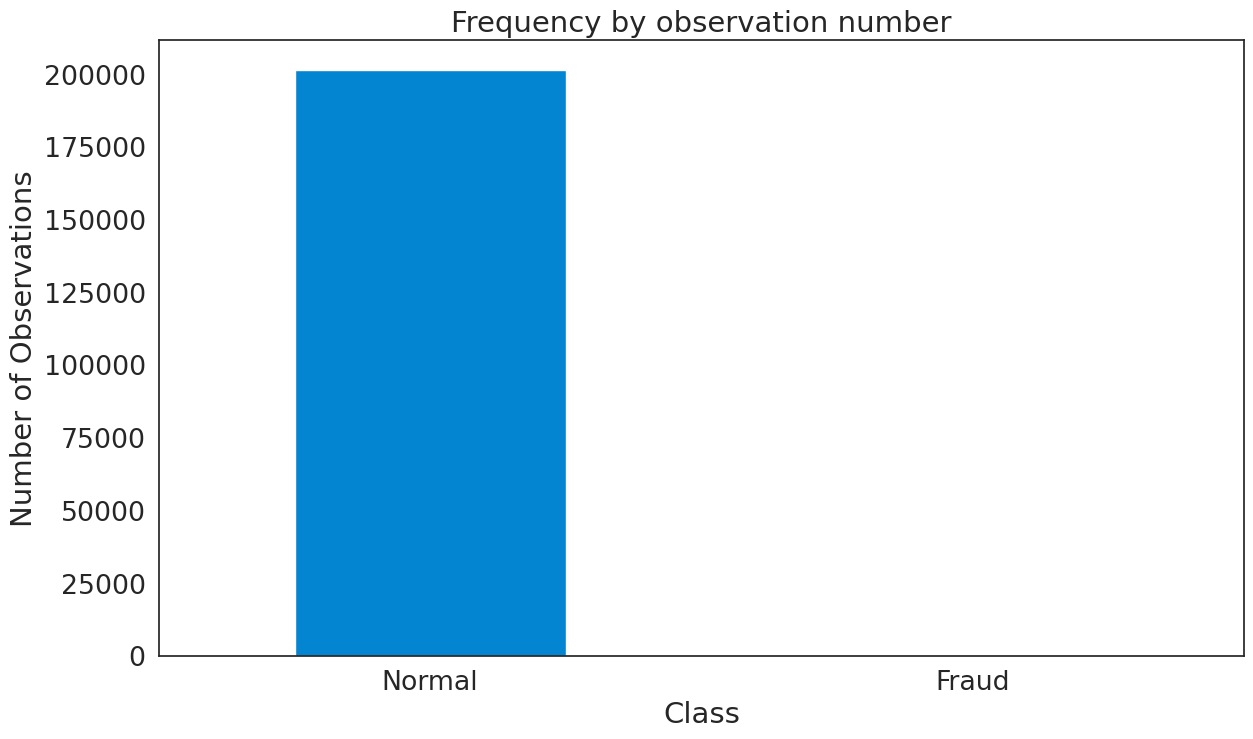

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, figsize=(14, 8))
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

# Focous on Normal Tranasctions

In [ ]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [ ]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)

train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

## Creating the Model

In [ ]:
nb_epoch = 50
batch_size = 128
learning_rate = 1e-7

In [ ]:
# This returns a tensor
input_layer = Input(shape=(30, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument,
# kernel is a weights matrix created by the layer, and
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(18, activation="tanh")(input_layer)
encoder = Dense(10, activation="elu")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
decoder = Dense(6, activation='elu')(encoder)
decoder = Dense(10, activation='tanh')(decoder)
decoder = Dense(30, activation='elu')(decoder)
# same structure of encoder and decoder is not required
# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 18)             │           558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 30)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,256 (4.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp]).history

Epoch 1/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3443 - loss: 0.8605

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3444 - loss: 0.8604 - val_accuracy: 0.5195 - val_loss: 0.7519
Epoch 2/50
1250/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5444 - loss: 0.6695

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5445 - loss: 0.6694 - val_accuracy: 0.5652 - val_loss: 0.6957
Epoch 3/50
1245/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5659 - loss: 0.6215

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5659 - loss: 0.6215 - val_accuracy: 0.5714 - val_loss: 0.6699
Epoch 4/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5765 - loss: 0.6018

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5765 - loss: 0.6018 - val_accuracy: 0.5934 - val_loss: 0.6513
Epoch 5/50
1248/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 0.5881

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5931 - loss: 0.5880 - val_accuracy: 0.6003 - val_loss: 0.6397
Epoch 6/50
1254/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5993 - loss: 0.5854

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5993 - loss: 0.5854 - val_accuracy: 0.6075 - val_loss: 0.6331
Epoch 7/50
1241/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6006 - loss: 0.5648

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6006 - loss: 0.5649 - val_accuracy: 0.6127 - val_loss: 0.6271
Epoch 8/50
1242/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6028 - loss: 0.5634

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6028 - loss: 0.5634 - val_accuracy: 0.6056 - val_loss: 0.6217
Epoch 9/50
1245/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6051 - loss: 0.5655

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6051 - loss: 0.5655 - val_accuracy: 0.6096 - val_loss: 0.6163
Epoch 10/50
1246/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6082 - loss: 0.5431

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6082 - loss: 0.5433 - val_accuracy: 0.6122 - val_loss: 0.6099
Epoch 11/50
1249/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6061 - loss: 0.5497

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6061 - loss: 0.5497 - val_accuracy: 0.6146 - val_loss: 0.6047
Epoch 12/50
1253/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6113 - loss: 0.5565

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6113 - loss: 0.5565 - val_accuracy: 0.6103 - val_loss: 0.6006
Epoch 13/50
1256/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6111 - loss: 0.5317

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6111 - loss: 0.5317 - val_accuracy: 0.6151 - val_loss: 0.5984
Epoch 14/50
1248/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6135 - loss: 0.5350

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6135 - loss: 0.5351 - val_accuracy: 0.6183 - val_loss: 0.5957
Epoch 15/50
1251/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6144 - loss: 0.5404

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6144 - loss: 0.5403 - val_accuracy: 0.6215 - val_loss: 0.5925
Epoch 16/50
1260/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6175 - loss: 0.5327

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6175 - loss: 0.5327 - val_accuracy: 0.6217 - val_loss: 0.5902
Epoch 17/50
1257/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6205 - loss: 0.5326

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6205 - loss: 0.5326 - val_accuracy: 0.6187 - val_loss: 0.5873
Epoch 18/50
1259/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6224 - loss: 0.5154

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6224 - loss: 0.5154 - val_accuracy: 0.6213 - val_loss: 0.5853
Epoch 19/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6235 - loss: 0.5230 - val_accuracy: 0.6174 - val_loss: 0.5854
Epoch 20/50
1249/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6231 - loss: 0.5209

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6231 - loss: 0.5209 - val_accuracy: 0.6214 - val_loss: 0.5840
Epoch 21/50
1243/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6240 - loss: 0.5159

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6240 - loss: 0.5160 - val_accuracy: 0.6229 - val_loss: 0.5807
Epoch 22/50
1254/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6213 - loss: 0.5244

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6213 - loss: 0.5244 - val_accuracy: 0.6241 - val_loss: 0.5796
Epoch 23/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6243 - loss: 0.5175 - val_accuracy: 0.6229 - val_loss: 0.5808
Epoch 24/50
1257/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.5218

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6250 - loss: 0.5218 - val_accuracy: 0.6193 - val_loss: 0.5782
Epoch 25/50
1260/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 0.5178

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6250 - loss: 0.5178 - val_accuracy: 0.6192 - val_loss: 0.5771
Epoch 26/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6258 - loss: 0.5178 - val_accuracy: 0.6207 - val_loss: 0.5773
Epoch 27/50
1258/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6234 - loss: 0.5284

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6234 - loss: 0.5283 - val_accuracy: 0.6249 - val_loss: 0.5757
Epoch 28/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6259 - loss: 0.5181 - val_accuracy: 0.6224 - val_loss: 0.5773
Epoch 29/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6246 - loss: 0.5298

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6246 - loss: 0.5298 - val_accuracy: 0.6253 - val_loss: 0.5743
Epoch 30/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6270 - loss: 0.5211 - val_accuracy: 0.6159 - val_loss: 0.5750
Epoch 31/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6257 - loss: 0.5155 - val_accuracy: 0.6282 - val_loss: 0.5780
Epoch 32/50
1248/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6298 - loss: 0.5145

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6298 - loss: 0.5145 - val_accuracy: 0.6241 - val_loss: 0.5731
Epoch 33/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6277 - loss: 0.5148

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6277 - loss: 0.5148 - val_accuracy: 0.6248 - val_loss: 0.5730
Epoch 34/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6292 - loss: 0.5085 - val_accuracy: 0.6288 - val_loss: 0.5735
Epoch 35/50
1253/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6278 - loss: 0.5085

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6278 - loss: 0.5086 - val_accuracy: 0.6307 - val_loss: 0.5717
Epoch 36/50
1259/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6299 - loss: 0.5054

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6299 - loss: 0.5054 - val_accuracy: 0.6295 - val_loss: 0.5714
Epoch 37/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6292 - loss: 0.5199 - val_accuracy: 0.6263 - val_loss: 0.5717
Epoch 38/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6298 - loss: 0.5015 - val_accuracy: 0.6173 - val_loss: 0.5723
Epoch 39/50
1254/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6289 - loss: 0.5205

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6289 - loss: 0.5204 - val_accuracy: 0.6310 - val_loss: 0.5699
Epoch 40/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6276 - loss: 0.5020 - val_accuracy: 0.6230 - val_loss: 0.5712
Epoch 41/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6276 - loss: 0.5051 - val_accuracy: 0.6301 - val_loss: 0.5718
Epoch 42/50
1254/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6268 - loss: 0.5104

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6268 - loss: 0.5104 - val_accuracy: 0.6347 - val_loss: 0.5683
Epoch 43/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6282 - loss: 0.5074 - val_accuracy: 0.6341 - val_loss: 0.5686
Epoch 44/50
1244/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6311 - loss: 0.5120

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6311 - loss: 0.5119 - val_accuracy: 0.6331 - val_loss: 0.5669
Epoch 45/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6303 - loss: 0.5162 - val_accuracy: 0.6343 - val_loss: 0.5672
Epoch 46/50
1251/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6304 - loss: 0.5070

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6303 - loss: 0.5070 - val_accuracy: 0.6319 - val_loss: 0.5659
Epoch 47/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6285 - loss: 0.5028 - val_accuracy: 0.6264 - val_loss: 0.5678
Epoch 48/50
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6292 - loss: 0.5067 - val_accuracy: 0.6289 - val_loss: 0.5666
Epoch 49/50
1243/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6307 - loss: 0.5138

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6306 - loss: 0.5137 - val_accuracy: 0.6358 - val_loss: 0.5655
Epoch 50/50
1246/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6294 - loss: 0.5006

1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6294 - loss: 0.5007 - val_accuracy: 0.6238 - val_loss: 0.5643


In [ ]:
autoencoder = load_model('autoencoder_fraud.h5')

## Model Evaluation


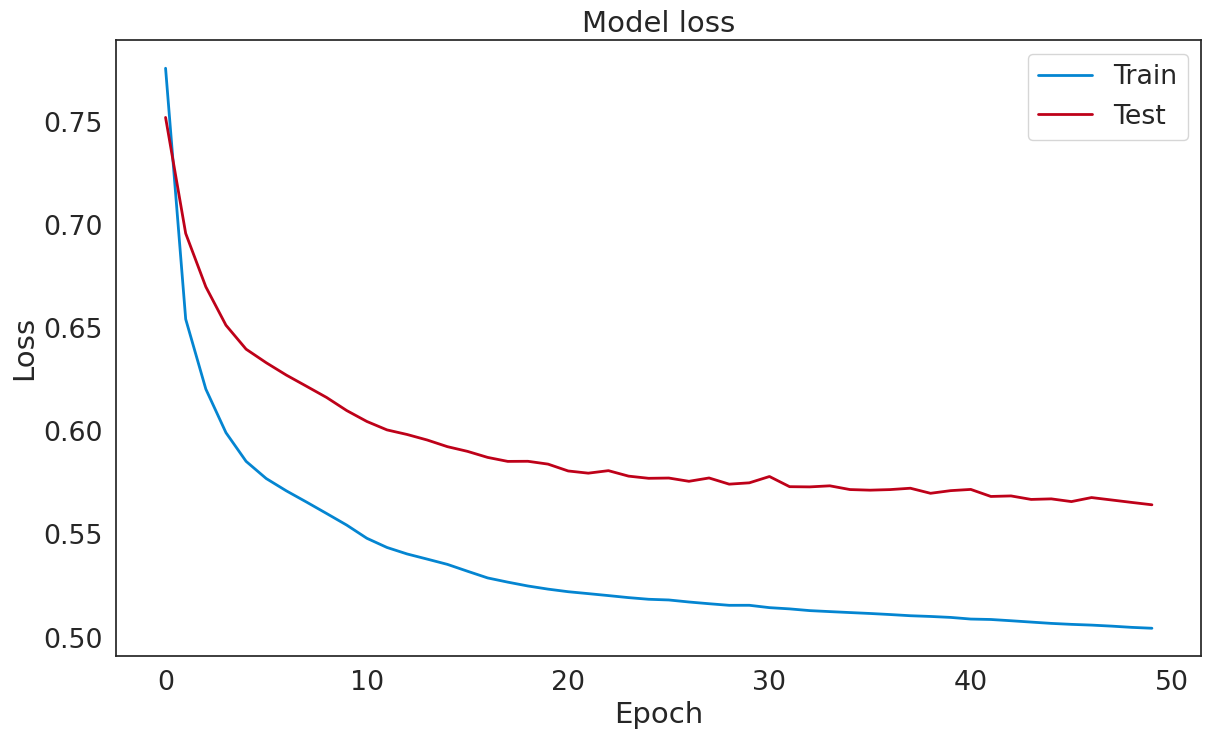

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Reconstruction Error Check

In [ ]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


,Reconstruction_error,True_class
count,40421.000000,40421.000000
mean,0.564310,0.002400
std,3.128807,0.048929
min,0.015282,0.000000
25%,0.149841,0.000000
50%,0.247526,0.000000
75%,0.412720,0.000000
max,133.968307,1.000000


## ROC Curve

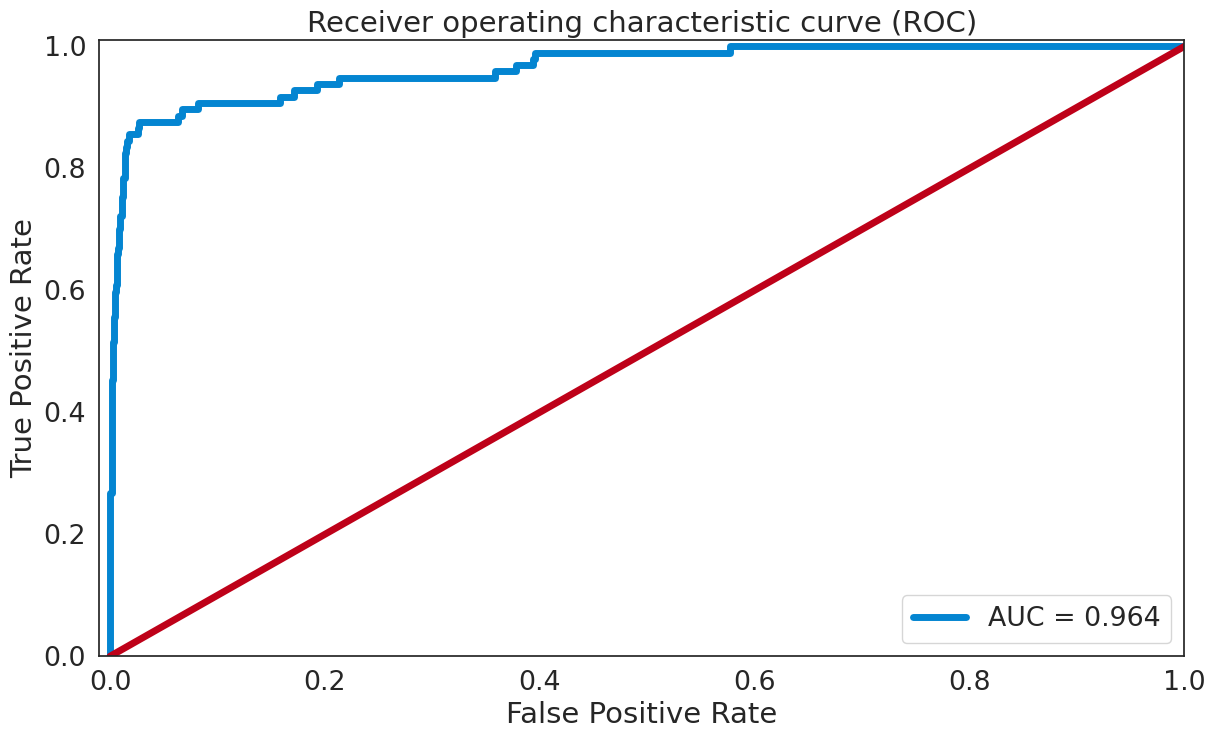

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Reconstruction Vs Threshold

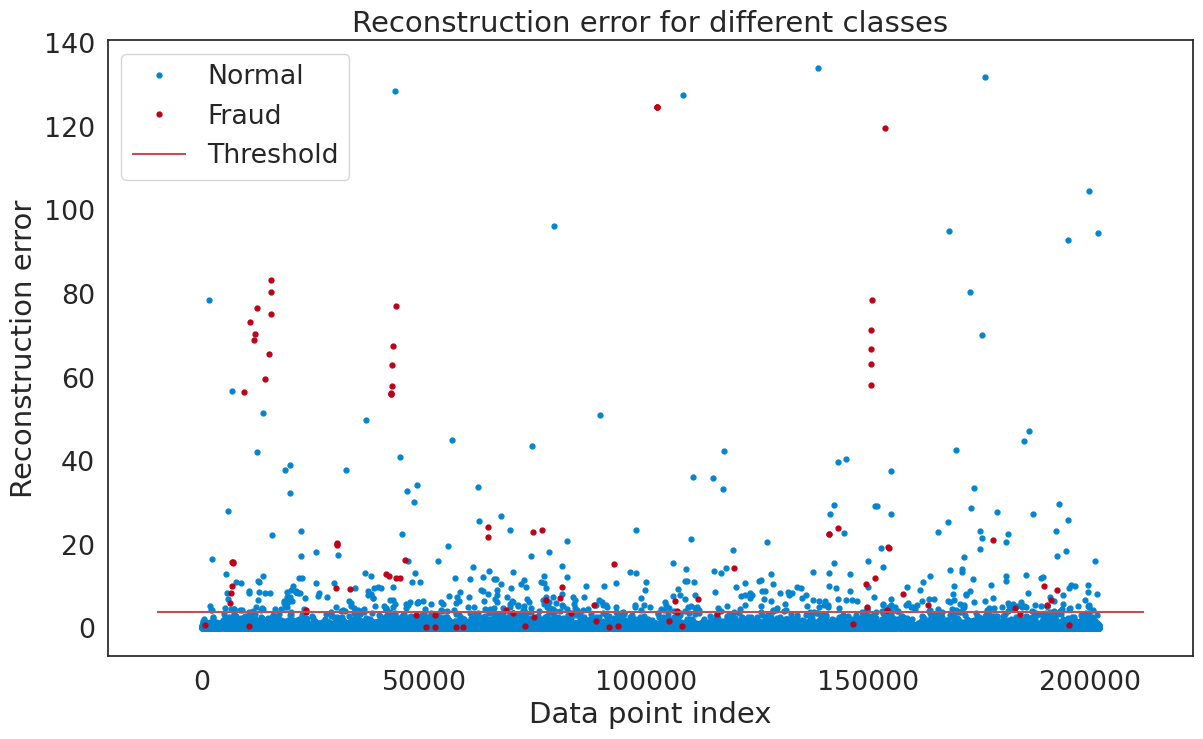

In [ ]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();